In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist



In [31]:
#reparametrization trick
class Sampling(Layer):

	def call(self, inputs):
		z_mean, z_log_var = inputs
		batch = tf.shape(z_mean)[0]
		dim = tf.shape(z_mean)[1]
		epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
		return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [32]:
# Encoder
latent_dim = 16

encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")

In [33]:
# Define Decoder Architecture
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")


In [34]:
# variational autoencoder class implementation
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super(VAE, self).__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder

	def train_step(self, data):
		if isinstance(data, tuple):
			data = data[0]
		with tf.GradientTape() as tape:
			z_mean, z_log_var, z = encoder(data)
			reconstruction = decoder(z)
			reconstruction_loss = tf.reduce_mean(
				keras.losses.binary_crossentropy(data, reconstruction)
			)
			reconstruction_loss *= 28 * 28
			kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
			kl_loss = tf.reduce_mean(kl_loss)
			kl_loss *= -0.5
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		return {
			"loss": total_loss,
			"reconstruction_loss": reconstruction_loss,
			"kl_loss": kl_loss,
		}

In [35]:
# Data loading
(x_train, _), (x_test, _) = mnist.load_data()
mnist_images = np.concatenate([x_train, x_test], axis = 0)
mnist_images = np.expand_dims(mnist_images, -1).astype("float32") / 255

# compiling and training the model
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(mnist_images, epochs = 30, batch_size = 64)

Epoch 1/30
1094/1094 [==============================] - 131s 118ms/step - loss: 156.4415 - reconstruction_loss: 153.9343 - kl_loss: 2.5072
Epoch 2/30
1094/1094 [==============================] - 129s 118ms/step - loss: 125.3154 - reconstruction_loss: 122.4202 - kl_loss: 2.8952
Epoch 3/30
1094/1094 [==============================] - 129s 118ms/step - loss: 119.7731 - reconstruction_loss: 116.8291 - kl_loss: 2.9441
Epoch 4/30
1094/1094 [==============================] - 130s 119ms/step - loss: 116.8227 - reconstruction_loss: 113.8851 - kl_loss: 2.9376
Epoch 5/30
1094/1094 [==============================] - 129s 118ms/step - loss: 114.8489 - reconstruction_loss: 111.9271 - kl_loss: 2.9218
Epoch 6/30
1094/1094 [==============================] - 129s 118ms/step - loss: 110.5934 - reconstruction_loss: 107.6005 - kl_loss: 2.9929
Epoch 7/30
1094/1094 [==============================] - 129s 118ms/step - loss: 106.5974 - reconstruction_loss: 103.5637 - kl_loss: 3.0337
Epoch 8/30
1094/1094 [=====

1/1 [==============================] - 0s 24ms/step


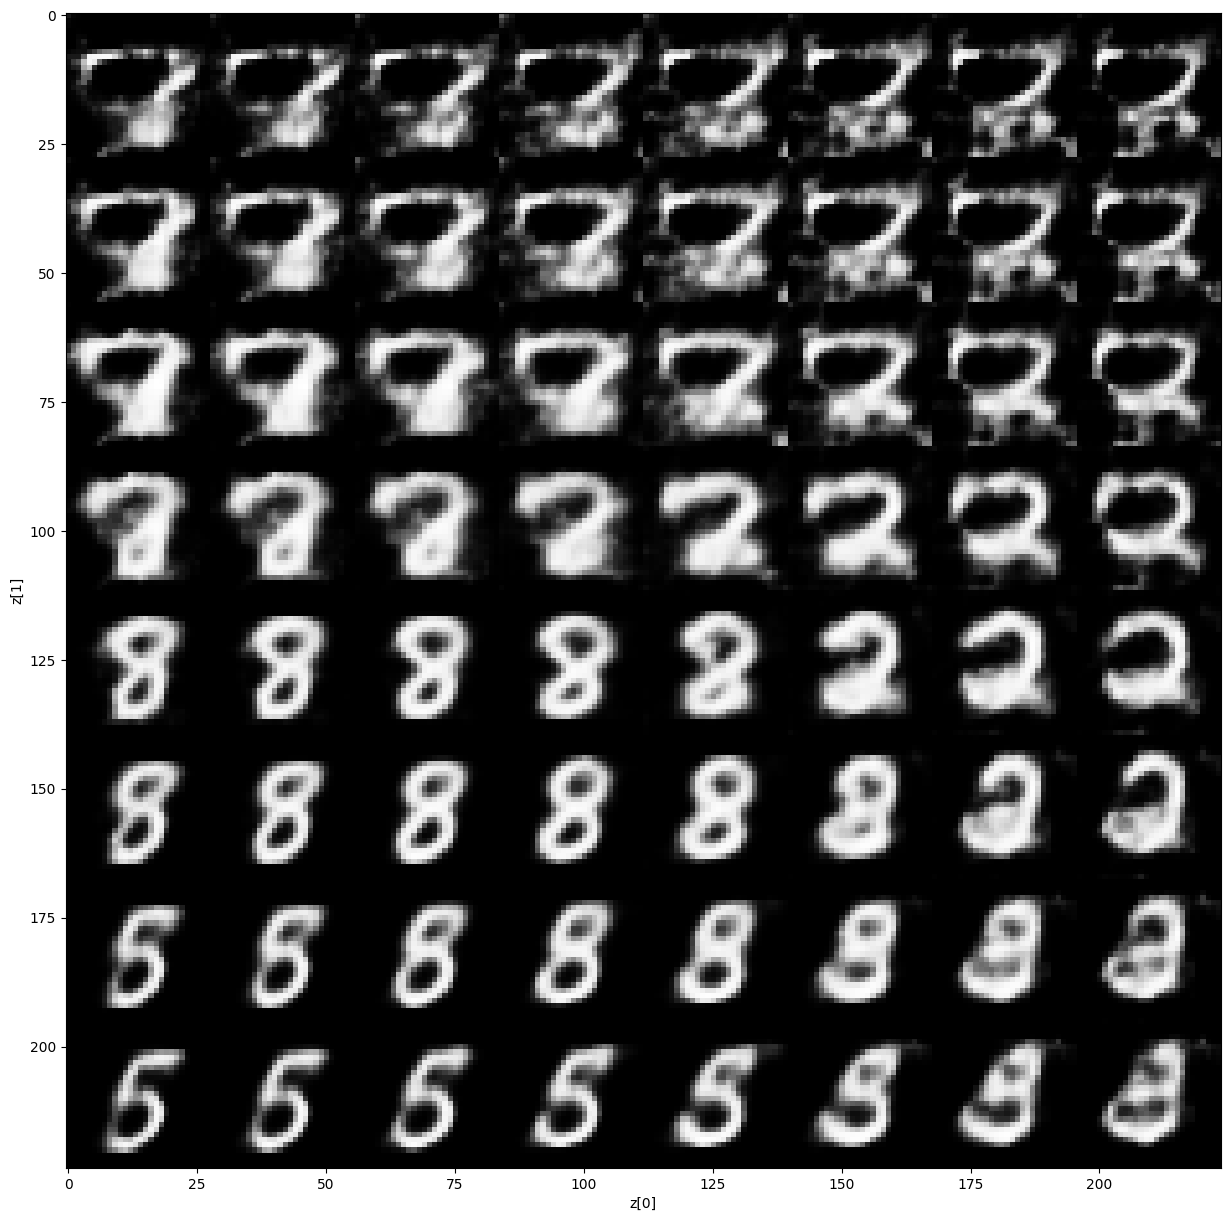

In [36]:
n = 8
img_dim = 28
scale = 4.0
figsize = 15
figure = np.zeros((img_dim * n, img_dim * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    x_decoded = decoder.predict(z_sample)
    images = x_decoded[0].reshape(img_dim, img_dim)
    figure[
      i * img_dim : (i + 1) * img_dim,
      j * img_dim : (j + 1) * img_dim,
    ] = images

plt.figure(figsize =(figsize, figsize))
start_range = img_dim // 2
end_range = n * img_dim + start_range + 1
pixel_range = np.arange(start_range, end_range, img_dim)
sample_range_x = np.round(np.linspace(-scale, scale, n), 1)
sample_range_y = np.round(np.linspace(-scale, scale, n)[::-1], 1)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap ="Greys_r")
plt.show()